# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

# 1. Подготовка данных

In [1]:
# Импортируем нужные библиотеки, метрики и пакеты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# Прочитаем наш датафрейм и выведем 5 значений на экран
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# Посмотрим общую информацию о датафрейме, наличие пропусков и типы столбцов
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Нам предоставили таблицу на 10 000 строк, и 13 признаков + целевой признак, который нужно будет научить модель предсказывать. Как видно из данных выше, у нас 3 признака имеют строковый тип данных, который нужно будет преобразовывать. Это Фамилия, Страна проживания и Пол. Фамилию я исключу из анализа, так как это признак сугубо уникальный и никак не влияет на то, останется ли клиент в банке, или же уйдет из него. Остальные два преобразуем техникой прямого кодирования. Так же есть проблемы с признаком - Количество недвижимости у клиента, там есть пропуски. Если данные признак будет существенным то нужно будет либо заполнить пропуски, либо исключить данные, где есть пропущенные значения. И я склонен ко второму варианту, хоть и удалять нужно будет примерно 10% наших данных, что не мало. Если заполнять пропущенные значения, средним, нулями или еще чем либо, мы будем повышать шум в наших данных, и наша модель может не корректно обучаться из-за этого, 10% искаженных данных может сильно повлиять на итоговый результат.

In [4]:
# Удаляем столбец с фамилией клиента
data = data.drop('Surname', axis=1)
# Используем технику прямого кодирования, причем с аргументом drop_first, чтобы избежать дамми-ловушки
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber            10000 non-null int64
CustomerId           10000 non-null int64
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               9091 non-null float64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(3), int64(8), uint8(3)
memory usage: 888.8 KB


Как видим, все столбцы приведены в нужный формат и можно двигаться далее. Поищем мультиколлинеарность и другие зависимости среди наших признаков. Посчитаем корреляцию и построим график.

In [5]:
data_ohe.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571,-0.000044,-0.009905,0.018196
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248,-0.003097,0.007800,-0.002641
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.005538,0.004780,-0.002857
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.046897,-0.001685,-0.027544
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761,-0.003299,0.000810,0.012634
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.401110,-0.134892,0.012087
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.010419,0.009039,-0.021859
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.010577,-0.013480,0.005766
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.020486,0.016732,0.022544
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.010297,-0.006482,-0.008112


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa29ee6ad90>,
      dtype=object)

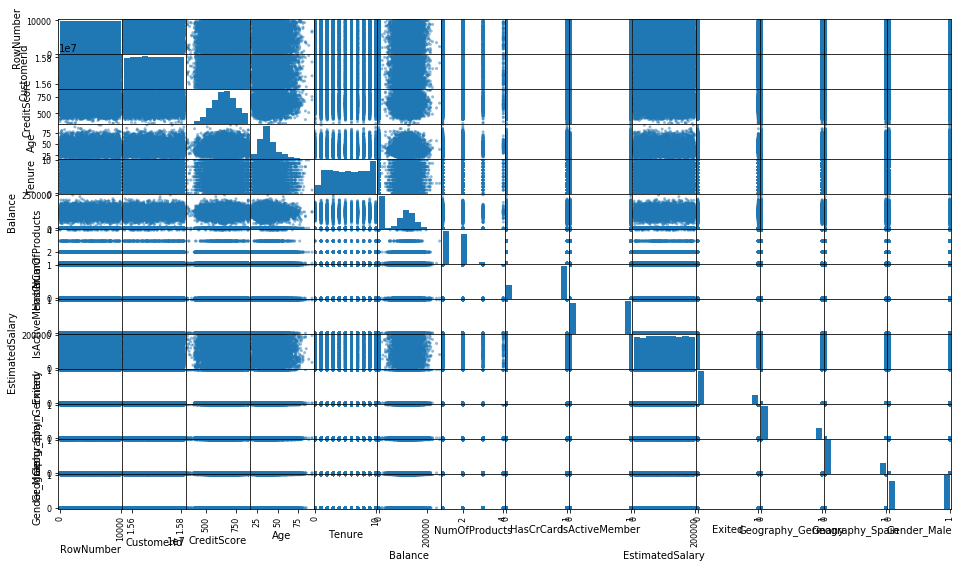

In [6]:
pd.plotting.scatter_matrix(data_ohe, figsize=(16, 9))

Как видно из матрицы и графика выше, у нас нет мультиколлинеарности. В большинстве случаев зависимости нет вообще, а даже если она и наблюдается, то она очень мало выраженная и не несет в себе сильного влияния на остальные признаки. Осталось разобраться, все ли признаки нам нужны для обучения модели. Чем признаков больше, тем сложнее и дольше идет обучения, как следствие рультаты при "переизбытке" признаков могут оказаться хуже. Для выявления выжности признаков используем статистику, а именно проверим гипотезу о равенстве средних двух генеральных совокупностей. Идея состоит в том, чтобы разбить наши данные на две совокупности по целевому признаку - в одной совокупности все клиенты остались в банке, в другой все кто ушел. Далее для каждого признака найдем значение p-value, и если оно будет выше порогового - 0.05, значит мы принимаем нулевую гипотезу, что средние двух совокупностей равны, а наш признак незначим, так как его значения не влияют на то, останется ли клиент в банке или уйдет. Так каку признака - Количество недвижимости у клиента, есть пропуски, удалим их на время, и если данный признак окажется важным, то либо либо оставим ученные данные, либо подумаем над заменами, а если окажется не важным, то просто его исключим, и тогда данные удалять не нужно будет. Так как значений много, то можно спользвать стандартный т-тест, на большой выборке он работает хорошо даже на не симетричных распределениях.

In [7]:
# Создадим тестовый датасет и исключим из него все пропуски
data_ohe_test = data_ohe.dropna()
# Разделим наше датасет на две выбоки
data_exit = data_ohe_test.query('Exited == 1')
data_not_exit = data_ohe_test.query('Exited != 1')
# С помощью цикла найдем значения p-value для каждого признака и сохраним его в переменной
for column in data:
    results = st.ttest_ind(data_exit, data_not_exit, equal_var = False)
data_proba = results.pvalue.round(3)
# Создадим новый датасет в котором у нас будут названия признаков и записаны значения p-value
name_features = data_ohe_test.columns
features_importance = pd.DataFrame(data_proba, name_features)
features_importance.columns = ['probability']
# Выведем на экран
features_importance

,probability
RowNumber,0.164
CustomerId,0.504
CreditScore,0.026
Age,0.000
Tenure,0.115
Balance,0.000
NumOfProducts,0.000
HasCrCard,0.607
IsActiveMember,0.000
EstimatedSalary,0.128


У следующих признаков значения p-value превышают наше пороговое альфа в 0.05: RowNumber, CustomerId, Tenure, HasCrCard, EstimatedSalary, что означает для этих признаков можно принять нулевую гипотезу о равенстве средних совокупностей, а значит эти признаки можно исключить из обучения.

Последний этап подготовки наших данных - это подготовить выборки для обучения. Так как у нас есть один большой датасет, а нам нужны три выборки - тренировочная, валидационная и тестовыя, то будем разбивать наши данны в два этапа. Сначала "отщипнем" 60% для тренировочной выборки, а оставшиеся 40% разобьем пополам, на валидационную и тестовую. Но перед этом подготовим наш целевой признак и оставшиеся признаки, убрав все не нужное.

In [8]:
# Исключаем малозначимые признаки
features = data_ohe.drop(['RowNumber', 'CustomerId', 'Tenure', 
                          'HasCrCard', 'EstimatedSalary', 'Exited'], axis=1)
# Выделяем целевой признак
target = data_ohe['Exited']

# Создаем тренировочные признаки и целевой признак
features_train, features_other, target_train, target_other = train_test_split(
features, target, test_size=0.4, random_state=12345)

# Создаем валидационные и тестовые признаки и целевые признаки
features_valid, features_test, target_valid, target_test = train_test_split(
features_other, target_other, test_size=0.5, random_state=12345)

Проверим как у нас сбалансированны классы. Для этого посмортим сколько у нас значений в целом признаке по каждому варианту.

In [9]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

На лицо дисбаланс, соотношение 1 к 4, не хорошо, но все решаемо.

### Вывод

Мы посмотрели наш датафрейм, проанализировали данные и признаки, исключили малозначимые, перекодировали категориальные признаки, проверили на мультиколлинеарность и даже проверили гипотезы из статистических методов, что позволило выявить малозначимые признаки. Так же подготовили данные для обучения: создали тренировочные, валидационные и тестовые признаки. Выявили что классы у нас не сбалансированны. Далее проведем исследование, посмотрим как модель обучается на несбалансированных данных, и посмотрим как мы сможем исправить данный дисбаланс, и как он повлияет на дальнейший результат.

# 2. Исследование задачи

Возьмем для исследования модель решаюшего дерева, через цикл подберем ей параметры и найдем наилучее значение F1-меры. Метрику accuracy нет смысла считать если классы несбалансированны. Гораздо показательнее будет рассчитать метрики полноты и точности, или f1-меру, которая обьединяет в себе среднегармоническое значение этих двух величин. Чем ближе значение f1-меры, тем лучше предсказывает наша модель. Если значение f1-меры равно 0.5, то значит наша модель работает так же как и случайная модель, если же значение f1-меры меньше 0.5, то модель работает плохо.

In [10]:
%%time
# Создание переменных
best_leaf_for_tree = 0
best_depth_for_tree = 0
best_f1_score = 0
best_crit_for_tree = 0
best_min_samples_leaf = 0

# Напишем цикл для перебора гиперпараметров
for crit in ['gini', 'entropy']:
    for leaf in range(10, 21):
        for depth in range(3, 11):
            for min_leaf in range(1, 11):
                model_tree = DecisionTreeClassifier(random_state=12345, criterion=crit, 
                                                max_depth=depth, max_leaf_nodes=leaf,
                                               min_samples_leaf=min_leaf)
                model_tree.fit(features_train, target_train)
                predictions_valid = model_tree.predict(features_valid)
                total_f1_score = f1_score(target_valid, predictions_valid)
                if best_f1_score < total_f1_score:
                    best_f1_score = total_f1_score
                    best_leaf_for_tree = leaf
                    best_depth_for_tree  = depth
                    best_crit_for_tree = crit
                    best_min_samples_leaf = min_leaf

# Вывод на экран получившихся начений
print("Выбираем лучшие параметры для нашей модели:")
print()
print("Наилучший критерий для оценки модели:", best_crit_for_tree)
print("Наилучшая губина дерева:", best_depth_for_tree)
print("Наилучшее максимальное количество листов в узле:", best_leaf_for_tree)
print("Наилучшее минимальное количество образцов в листе:", best_min_samples_leaf)
print("Наилучшее значение F1-меры:", best_f1_score)

Выбираем лучшие параметры для нашей модели:

Наилучший критерий для оценки модели: gini
Наилучшая губина дерева: 6
Наилучшее максимальное количество листов в узле: 17
Наилучшее минимальное количество образцов в листе: 1
Наилучшее значение F1-меры: 0.5684210526315789
CPU times: user 25.8 s, sys: 5.66 ms, total: 25.9 s
Wall time: 25.9 s


Параметры подобраны, теперь используя наши параметры посмотрим какое значение у нас получится на тестовых данных.

In [11]:
model_tree = DecisionTreeClassifier(random_state=12345, criterion=best_crit_for_tree, 
                                    max_depth=best_depth_for_tree, max_leaf_nodes=best_leaf_for_tree,
                                    min_samples_leaf=best_min_samples_leaf)
model_tree.fit(features_train, target_train)

# Проверка модели на тестовых данных
prediction_test_tree = model_tree.predict(features_test)
f1_score(target_test, prediction_test_tree).round(4)

0.5347

Совсем не густо, далековато от нашего целевого ориентира в 0.59. Выведем показатели полноты, точности и f1-меры, построим матрицу матрицу ошибок и нарисуем график.

In [12]:
report = classification_report(target_test, prediction_test_tree)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1577
           1       0.74      0.42      0.53       423

    accuracy                           0.85      2000
   macro avg       0.80      0.69      0.72      2000
weighted avg       0.83      0.85      0.83      2000



Precision можно интерпретировать как доля объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм. Судя по цифрам, наша модель очень хорошо находит клиентов которые не уйдут из банка, а вот с теми кто перестает быть клиентом, справляется плохо, видимо ей не хватило обучающих данных по уходящим клиентам.

In [13]:
conf_matrix = pd.DataFrame(confusion_matrix(target_test, prediction_test_tree))
conf_matrix

,0,1
0,1515,62
1,246,177


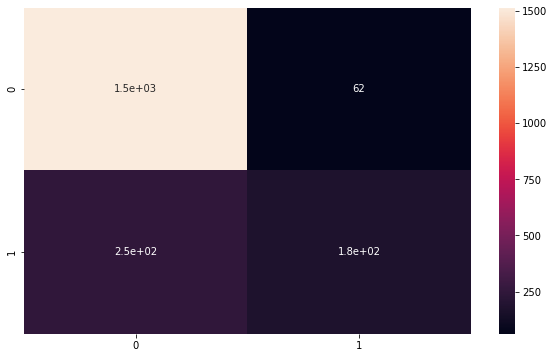

In [14]:
plt.figure(figsize = (10,6))
sn.heatmap(conf_matrix, annot=True)

Мы видим, что наша модель ошибается на 2000 предсказаний в 308 случаях, причем в 246 случаях она уверяет что клиент не уйдет, а на самом деле он уходит, что совсем не хорошо. Нужно исправлять дисбаланс и переобучать модель.

Посчитаем значение AUC-ROC и построим график кривой, для закрепления точки отсчета.
Показатель AUC-ROC в идеальных условиях стремится к 1, у случайной модели равен 0.5, чем выше значение, тем лучше работает модель.

In [15]:
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.8165781005208113

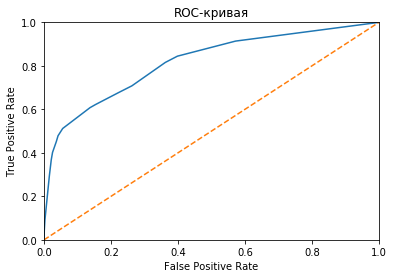

In [16]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
# < примените функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1 >
plt.xlim(0, 1)
plt.ylim(0, 1)
# < примените функции plt.xlabel() и plt.ylabel(), чтобы
#   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# < добавьте к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

### Вывод

Была обучена модель на несбалансированных данных, посчитаны метрики и выявлено что наша модель не дообучилась, ей на хватает данных чтобы хорошо определять "отточных" клиентов. Решений здесь несколько, можно взвесить классы при обучении модели, и "малочисленные" классы получат больший вес при обучении, что позволит добиться более высоких результатов в метриках. Так же можно применить метод Увеличения выборки, увеличив число "отточных" клиентов до такого же значения как и "не отточных". Для оценки качества "борьбы" с дисбалансом будем опираться на значения f1-меры и значения AUC-ROC, текущие значения мы посчитали, теперь цель их увеличить.

# 3. Борьба с дисбалансом

У нас дисбаланс классов и модель предсказывает не очень хорошо, хотелось бы улучшить качество метрик, перед выпуском модели в продакшн. Решить эту проблему можно тремя основными способами (на самом деле есть и еще способы, например снижение порога классификации, но протестируем мы модели на трех способах):
- присвоить всем классам веса, так что малочисленные классы будут иметь больший вес (важность) при обучении модели;
- сделать увеличение выборки, добавив значения в наш малочесленный класс, чтобы "уравнять" баланс;
- сделать уменьшение выборки, убрав часть неважных, "уровняв" классы.

Возьмем три модели:
- Решающее дерево;
- Случайный лес;
- Логистическую регрессию.

Каждую модель обучим с помощью взвешивания классов, увеличения и уменьшения выборок. После отберем самые удачные варианты моделей и посмотрим на результат на тестовой выборке.

Для начала создадим функции которые подговят нам увеличенную и уменьшенную выборки для обучения.

In [17]:
# Создаем функцию для увеличения обучающей выборки
def upsample(features, target, repeat):
    # Задаём переменные
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # С помощью функции concat сцепляем отрицательные признаки с положительными признаками 
    # увеличенными на задаваемое нами число раз. Тоже самое проделываем с целевым признаком
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # Перемешиваем данные, чтобы небыло повтояющихся циклов и модель лучше обучалась
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

# Создаем две переменные которые будем использовать для обучения. Число 4 выбрано не случайно, так как
# отрицательных признаков больше в 4 раза чем положительных, нужно уравнять классы
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
# посмтрим на размерности выборок
print(features_upsampled[target == 0].shape)
print(features_upsampled[target == 1].shape)
print(target_upsampled[target == 0].shape)
print(target_upsampled[target == 1].shape)

(4804, 8)
(4784, 8)
(4804,)
(4784,)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [18]:
# Создаем функцию для уменьшения обучающей выборки
def downsample(features, target, fraction):
    # Задаём переменные
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # С помощью функции concat сцепляем положительныt признаки с отрицательными признаками
    # уменьшенными на задаваемое нами число раз. Тоже самое проделываем с целевым признаком
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    # Перемешиваем данные, чтобы небыло повтояющихся циклов и модель лучше обучалась
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

# Создаем две переменные которые будем использовать для обучения. Число 0,25 выбрано не случайно, 
# так как отрицательных признаков больше в 4 раза чем положительных, нужно уравнять классы
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

# посмтрим на размерности выборок
print(features_downsampled[target == 0].shape)
print(target_downsampled[target == 1].shape)
print(target_downsampled[target == 0].shape)
print(target_downsampled[target == 1].shape)

(1201, 8)
(1196,)
(1201,)
(1196,)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Выборки готовы, классы практически уравняли, можно приступать к обучению. Начнем с решающего дерева.
Для начала обучим модель с подбором гиперпараметров с помощью взвешивания классов, потом вместо обучающей выборки будем использовать сэмплированые (увеличенную и уменьшенную) и из полученных вариантов для каждой модели отберем самый лучший, который и будем испытвать на тестовой выборке.

In [19]:
%%time
# Создание переменных
best_leaf_for_tree = 0
best_depth_for_tree = 0
best_f1_score = 0
best_crit_for_tree = 0

# Напишем цикл для перебора гиперпараметров
for crit in ['gini', 'entropy']:
    for leaf in range(10, 21):
        for depth in range(3, 21):
            model_tree = DecisionTreeClassifier(random_state=12345, criterion=crit, 
                                                max_depth=depth, max_leaf_nodes=leaf,
                                               class_weight='balanced')
            model_tree.fit(features_train, target_train)
            predictions_valid = model_tree.predict(features_valid)
            total_f1_score = f1_score(target_valid, predictions_valid)
            if best_f1_score < total_f1_score:
                best_f1_score = total_f1_score
                best_leaf_for_tree = leaf
                best_depth_for_tree  = depth
                best_crit_for_tree = crit

# Вывод на экран получившихся начений
print("Выбираем лучшие параметры для нашей модели:")
print()
print("Наилучший критерий для оценки модели:", best_crit_for_tree)
print("Наилучшая губина дерева:", best_depth_for_tree)
print("Наилучшее максимальное количество листов в узле:", best_leaf_for_tree)
print("Наилучшее значение F1-меры:", best_f1_score)

Выбираем лучшие параметры для нашей модели:

Наилучший критерий для оценки модели: entropy
Наилучшая губина дерева: 5
Наилучшее максимальное количество листов в узле: 15
Наилучшее значение F1-меры: 0.603174603174603
CPU times: user 6.9 s, sys: 15.2 ms, total: 6.91 s
Wall time: 6.94 s


In [20]:
%%time
# Создание переменных
best_leaf_for_tree = 0
best_depth_for_tree = 0
best_f1_score = 0
best_crit_for_tree = 0

# Напишем цикл для перебора гиперпараметров
for crit in ['gini', 'entropy']:
    for leaf in range(10, 21):
        for depth in range(3, 21):
            model_tree = DecisionTreeClassifier(random_state=12345, criterion=crit, 
                                                max_depth=depth, max_leaf_nodes=leaf)
            model_tree.fit(features_upsampled, target_upsampled)
            predictions_valid = model_tree.predict(features_valid)
            total_f1_score = f1_score(target_valid, predictions_valid)
            if best_f1_score < total_f1_score:
                best_f1_score = total_f1_score
                best_leaf_for_tree = leaf
                best_depth_for_tree  = depth
                best_crit_for_tree = crit

# Вывод на экран получившихся начений
print("Выбираем лучшие параметры для нашей модели:")
print()
print("Наилучший критерий для оценки модели:", best_crit_for_tree)
print("Наилучшая губина дерева:", best_depth_for_tree)
print("Наилучшее максимальное количество листов в узле:", best_leaf_for_tree)
print("Наилучшее значение F1-меры:", best_f1_score)

Выбираем лучшие параметры для нашей модели:

Наилучший критерий для оценки модели: entropy
Наилучшая губина дерева: 5
Наилучшее максимальное количество листов в узле: 15
Наилучшее значение F1-меры: 0.603174603174603
CPU times: user 8.34 s, sys: 14.9 ms, total: 8.36 s
Wall time: 8.38 s


In [21]:
%%time
# Создание переменных
best_leaf_for_tree = 0
best_depth_for_tree = 0
best_f1_score = 0
best_crit_for_tree = 0

# Напишем цикл для перебора гиперпараметров
for crit in ['gini', 'entropy']:
    for leaf in range(10, 21):
        for depth in range(3, 21):
            model_tree = DecisionTreeClassifier(random_state=12345, criterion=crit, 
                                                max_depth=depth, max_leaf_nodes=leaf)
            model_tree.fit(features_downsampled, target_downsampled)
            predictions_valid = model_tree.predict(features_valid)
            total_f1_score = f1_score(target_valid, predictions_valid)
            if best_f1_score < total_f1_score:
                best_f1_score = total_f1_score
                best_leaf_for_tree = leaf
                best_depth_for_tree  = depth
                best_crit_for_tree = crit

# Вывод на экран получившихся начений
print("Выбираем лучшие параметры для нашей модели:")
print()
print("Наилучший критерий для оценки модели:", best_crit_for_tree)
print("Наилучшая губина дерева:", best_depth_for_tree)
print("Наилучшее максимальное количество листов в узле:", best_leaf_for_tree)
print("Наилучшее значение F1-меры:", best_f1_score)

Выбираем лучшие параметры для нашей модели:

Наилучший критерий для оценки модели: entropy
Наилучшая губина дерева: 6
Наилучшее максимальное количество листов в узле: 12
Наилучшее значение F1-меры: 0.6015037593984962
CPU times: user 3.7 s, sys: 6.51 ms, total: 3.7 s
Wall time: 3.73 s


Модель со взвешиваем классов показала такой же результат как и модель которая обучалась на увеличенной выборке, только затратила на обучение чуть меньше времени, что говорит о выборе в пользу нее для тестирования.

Теперь перйдем к регрессии, посмотрим какой результат покажет данная модель.

In [22]:
# Создаем списки со значениями гиперпараметров
C = [0.01, 0.1, 1, 10, 100]

# Создаем переменные для записи лучших значений гиперпараметров
best_f1_score_regression = 0
best_C = 0

# Напишем цикл для перебора гиперпараметров
for value in C:
    model_reg = LogisticRegression(random_state=12345, solver='liblinear', 
                                   C=value, class_weight='balanced')
    model_reg.fit(features_train, target_train)
    predictions_valid = model_reg.predict(features_valid)
    total_f1_score = f1_score(target_valid, predictions_valid)
    if best_f1_score_regression < total_f1_score:
        best_f1_score_regression = total_f1_score
        best_C = value
                    
print("Выбираем лучшие параметры для нашей модели:")
print()
print("Наилучшее значение регуляции:", best_C)
print("Наилучшее значние точности определения:", best_f1_score_regression)

Выбираем лучшие параметры для нашей модели:

Наилучшее значение регуляции: 10
Наилучшее значние точности определения: 0.45599999999999996


In [23]:
# Создаем списки со значениями гиперпараметров
C = [0.01, 0.1, 1, 10, 100]

# Создаем переменные для записи лучших значений гиперпараметров
best_f1_score_regression = 0
best_C = 0

# Напишем цикл для перебора гиперпараметров
for value in C:
    model_reg = LogisticRegression(random_state=12345, solver='liblinear', C=value)
    model_reg.fit(features_upsampled, target_upsampled)
    predictions_valid = model_reg.predict(features_valid)
    total_f1_score = f1_score(target_valid, predictions_valid)
    if best_f1_score_regression < total_f1_score:
        best_f1_score_regression = total_f1_score
        best_C = value
                    
print("Выбираем лучшие параметры для нашей модели:")
print()
print("Наилучшее значение регуляции:", best_C)
print("Наилучшее значние точности определения:", best_f1_score_regression)

Выбираем лучшие параметры для нашей модели:

Наилучшее значение регуляции: 0.01
Наилучшее значние точности определения: 0.4446215139442231


In [24]:
# Создаем списки со значениями гиперпараметров
C = [0.01, 0.1, 1, 10, 100]

# Создаем переменные для записи лучших значений гиперпараметров
best_f1_score_regression = 0
best_C = 0

# Напишем цикл для перебора гиперпараметров
for value in C:
    model_reg = LogisticRegression(random_state=12345, solver='liblinear', C=value)
    model_reg.fit(features_downsampled, target_downsampled)
    predictions_valid = model_reg.predict(features_valid)
    total_f1_score = f1_score(target_valid, predictions_valid)
    if best_f1_score_regression < total_f1_score:
        best_f1_score_regression = total_f1_score
        best_C = value
                    
print("Выбираем лучшие параметры для нашей модели:")
print()
print("Наилучшее значение регуляции:", best_C)
print("Наилучшее значние точности определения:", best_f1_score_regression)

Выбираем лучшие параметры для нашей модели:

Наилучшее значение регуляции: 0.01
Наилучшее значние точности определения: 0.44426877470355736


И снова победило взвешивание классов, переходим к случайному лесу.

In [25]:
%%time
# Создание переменных
best_leaf_forest = 0
best_depth_forest = 0
best_f1_score_forest = 0
best_crit_forest = 0
best_estimators_forest = 0

# Напишем цикл для перебора гиперпараметров
for crit in ['gini', 'entropy']:
    for leaf in range(7, 16):
        for depth in range(2, 11):
            for estim in range(70, 101, 5):
                model_forest = RandomForestClassifier(random_state=12345, n_estimators=estim,
                                                     criterion=crit, max_depth=depth, 
                                                      max_leaf_nodes=leaf, class_weight='balanced')
                model_forest.fit(features_train, target_train)
                predictions_valid = model_forest.predict(features_valid)
                total_f1_score = f1_score(target_valid, predictions_valid)
                if best_f1_score_forest < total_f1_score:
                    best_f1_score_forest = total_f1_score
                    best_leaf_forest = leaf
                    best_depth_forest = depth
                    best_crit_forest = crit
                    best_estimators_forest = estim
                    
# Вывод на экран получившихся начений
print("Выбираем лучшие параметры для нашей модели:")
print()
print("Наилучший критерий для оценки модели:", best_crit_forest)
print("Наилучшая губина дерева:", best_depth_forest)
print("Наилучшее максимальное количество листов в узле:", best_leaf_forest)
print("Наилучшее максимальное количество деревьев в лесу:", best_estimators_forest)
print("Наилучшее значние точности определения:", best_f1_score_forest)

Выбираем лучшие параметры для нашей модели:

Наилучший критерий для оценки модели: gini
Наилучшая губина дерева: 6
Наилучшее максимальное количество листов в узле: 15
Наилучшее максимальное количество деревьев в лесу: 95
Наилучшее значние точности определения: 0.6056475170399221
CPU times: user 6min 37s, sys: 1.81 s, total: 6min 39s
Wall time: 6min 40s


In [26]:
%%time
# Создание переменных
best_leaf_forest = 0
best_depth_forest = 0
best_f1_score_forest = 0
best_crit_forest = 0
best_estimators_forest = 0

# Напишем цикл для перебора гиперпараметров
for crit in ['gini', 'entropy']:
    for leaf in range(7, 16):
        for depth in range(2, 11):
            for estim in range(70, 101, 5):
                model_forest = RandomForestClassifier(random_state=12345, n_estimators=estim,
                                                     criterion=crit, max_depth=depth, 
                                                      max_leaf_nodes=leaf)
                model_forest.fit(features_upsampled, target_upsampled)
                predictions_valid = model_forest.predict(features_valid)
                total_f1_score = f1_score(target_valid, predictions_valid)
                if best_f1_score_forest < total_f1_score:
                    best_f1_score_forest = total_f1_score
                    best_leaf_forest = leaf
                    best_depth_forest = depth
                    best_crit_forest = crit
                    best_estimators_forest = estim
                    
# Вывод на экран получившихся начений
print("Выбираем лучшие параметры для нашей модели:")
print()
print("Наилучший критерий для оценки модели:", best_crit_forest)
print("Наилучшая губина дерева:", best_depth_forest)
print("Наилучшее максимальное количество листов в узле:", best_leaf_forest)
print("Наилучшее максимальное количество деревьев в лесу:", best_estimators_forest)
print("Наилучшее значние точности определения:", best_f1_score_forest)

Выбираем лучшие параметры для нашей модели:

Наилучший критерий для оценки модели: entropy
Наилучшая губина дерева: 9
Наилучшее максимальное количество листов в узле: 13
Наилучшее максимальное количество деревьев в лесу: 95
Наилучшее значние точности определения: 0.6068965517241379
CPU times: user 8min 52s, sys: 2.01 s, total: 8min 54s
Wall time: 8min 55s


In [27]:
%%time
# Создание переменных
best_leaf_forest = 0
best_depth_forest = 0
best_f1_score_forest = 0
best_crit_forest = 0
best_estimators_forest = 0

# Напишем цикл для перебора гиперпараметров
for crit in ['gini', 'entropy']:
    for leaf in range(7, 16):
        for depth in range(2, 11):
            for estim in range(70, 101, 5):
                model_forest = RandomForestClassifier(random_state=12345, n_estimators=estim,
                                                     criterion=crit, max_depth=depth, 
                                                      max_leaf_nodes=leaf)
                model_forest.fit(features_downsampled, target_downsampled)
                predictions_valid = model_forest.predict(features_valid)
                total_f1_score = f1_score(target_valid, predictions_valid)
                if best_f1_score_forest < total_f1_score:
                    best_f1_score_forest = total_f1_score
                    best_leaf_forest = leaf
                    best_depth_forest = depth
                    best_crit_forest = crit
                    best_estimators_forest = estim
                    
# Вывод на экран получившихся начений
print("Выбираем лучшие параметры для нашей модели:")
print()
print("Наилучший критерий для оценки модели:", best_crit_forest)
print("Наилучшая губина дерева:", best_depth_forest)
print("Наилучшее максимальное количество листов в узле:", best_leaf_forest)
print("Наилучшее максимальное количество деревьев в лесу:", best_estimators_forest)
print("Наилучшее значние точности определения:", best_f1_score_forest)

Выбираем лучшие параметры для нашей модели:

Наилучший критерий для оценки модели: entropy
Наилучшая губина дерева: 6
Наилучшее максимальное количество листов в узле: 13
Наилучшее максимальное количество деревьев в лесу: 85
Наилучшее значние точности определения: 0.5992292870905588
CPU times: user 4min 30s, sys: 1.64 s, total: 4min 32s
Wall time: 4min 33s


А вот в данной модели наилучшее значение метрики получилось у модели, которая обучалась на увеличинной выборке, а по времени это заняло на треть дольше, к тому же разница минимальная - 0.001. Поэтому в дальнейшем будем использовать при обучении и прогнозировании параметр взвешивания классов, без семплирования.

### Вывод

Мы выбрали три модели для тестирования. Для каждой модели мы провели обучение компанисируя дисбаланс классов. Был использован параметр *class_weight='balanced'* при обучении каждой модели. Так же было проведено обучение на увеличенной и уменьшенной выборках с целью минимизировать дисбалнс. Для каждой модели мы выбрали наилучший вариант обучения, наилучшие гиперпараметры, теперь можно переходить к 4 этапу и тестировать наши модели.

# 4. Тестирование модели

Перед тем как переходить к тестутированию модели, нам нужно объединить валидационную и тренировочную выборки в одну, и уже на ней будем обучать наши итоговые модели. Так же нужно будет проделать процедуру unsampling`а для новых обучающих данных. 

In [28]:
# Объединяем тренировочные и валидацонные признаки в одну выборку
full_features_train = pd.concat([features_train, features_valid])
# Аналогично с целевым признаком
full_target_train = pd.concat([target_train, target_valid])

Данные подготовлены, можно приступать к тестированию

In [29]:
model_tree = DecisionTreeClassifier(random_state=12345, criterion='entropy', 
                                    max_depth=5, max_leaf_nodes=15,
                                    class_weight='balanced')
model_tree.fit(full_features_train, full_target_train)

# Проверка модели на тестовых данных
prediction_test_tree = model_tree.predict(features_test)
f1_score(target_test, prediction_test_tree).round(4)

0.5749

In [30]:
model_log_regression = LogisticRegression(random_state=12345, 
                               solver='liblinear', C=10, class_weight='balanced')
model_log_regression.fit(full_features_train, full_target_train)
prediction_test_forest = model_log_regression.predict(features_test)
f1_score(target_test, prediction_test_forest).round(4)

0.4428

In [31]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      n_estimators=95, 
                                      criterion='gini', 
                                      max_depth=6, 
                                      max_leaf_nodes=15,
                                     class_weight='balanced')
model_forest.fit(full_features_train, full_target_train)

prediction_forest_test = model_forest.predict(features_test)
f1_score(target_test, prediction_forest_test).round(4)

0.6008

Заветное значение метрики f1-меры чуть превысило целевой. Победил Случайный лес!), собственно как и всегда на текущем этапе обучения, за последний месяц.

Остается посмотреть и сравнить параметры которые были получены на модели обученной на несбалансированных классах, с текущими результатами.

In [32]:
report = classification_report(target_test, prediction_forest_test)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1577
           1       0.51      0.73      0.60       423

    accuracy                           0.80      2000
   macro avg       0.71      0.77      0.73      2000
weighted avg       0.83      0.80      0.81      2000



Как видно из рассчетов, "отточных клиентов" просела точность, но возросла полнота, что позволило увеличить значение метрики с 0.5347 до 0.6008, чем ближе значение данной метрики к 1, тем лучше работает модель.

In [33]:
conf_matrix = pd.DataFrame(confusion_matrix(target_test, prediction_forest_test))
conf_matrix

,0,1
0,1285,292
1,116,307


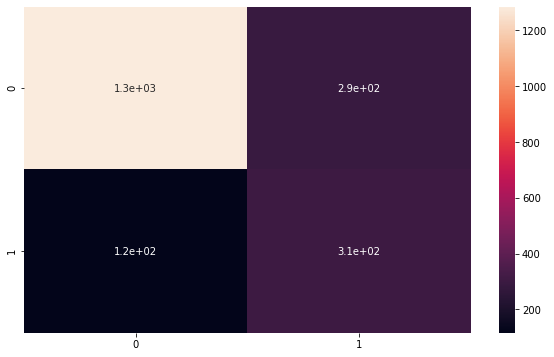

In [34]:
plt.figure(figsize = (10,6))
sn.heatmap(conf_matrix, annot=True)

по показателям confusion_matrix тоже заметны улучшения, модель стала точнее определять TP (истинно положительных) клиентов - сейчас их было найдено 307, а ранее было найдено только 177, так же уменьшилось количество FN (ложноотрицательных ответов) - 246 против 116. Правда есть и ложка дегтя) - а именно по TN и FP модель просела.

In [35]:
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.8564510128902305

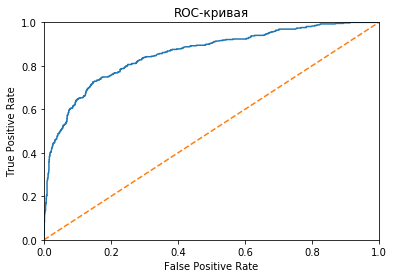

In [36]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure()
plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
# < примените функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1 >
plt.xlim(0, 1)
plt.ylim(0, 1)
# < примените функции plt.xlabel() и plt.ylabel(), чтобы
#   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# < добавьте к графику заголовок "ROC-кривая" функцией plt.title() >
plt.title('ROC-кривая')
plt.show()

AUC-ROC тоже вырос, с 0.8165 до 0.8564, что тоже свидетельствует об улучшеннии нашей модели, кривая стала чуть повыше, а значит модель стала угадывать правильные значения допуская меньше ошибок.

## Вывод

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

По предоставленным данным был проведен анализ и обработка, были выявлены наиболее важные признаки, которые в дальнейшем были использованы для обучения прогнозной модели. Было выявлено несбалансированность классов, проведено обучение модели с дибсалансом. Дисбаланс классов был устранен, используя несколько методов, протестировано три модели, и выбрана одна, которая могла превысить целовой показатель метрики f1-мера в 0.59, а именно получить велечину метрики в 0.6008. Модель стала точнее находить клиентов, которые стремятся покинуть банк, что собственно и требовалось.